# Energy and time Predictions for the kinarm reaching model. 

In the following code we create a kinarm model and perform optimizations to find the trajectories and movement times for reaches of different distances, and different valuations of time.

if you set 'theGeneratePlots=1', you will get 6 plots per optimization.


In [4]:
#%% Loop across distances and valuations to generate double-pendulum distance/time predictions. 
import ReachingModels as reaching
import numpy as np
import matplotlib.pyplot as plt
import colour as clr
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(0,'parameterFiles')

# model that has equations to compute endpoint jacobians, equations of motion, and energy. 
sim = reaching.Kinarm()
#sim = reaching.PointMass()

# starting x and y
x = 0.0
ys = 0.20
xystart = np.array([x,ys])

loopValuation = [.25,.5,.75,1,3,5,7,20,70,100]
loopdist = np.array([.005, .01, .025, .05, .075, .1, .2, .25, .3, .35, .4, .45, .5])

color1 = clr.Color("#e0f3db")
distcolors = list(color1.range_to(clr.Color("#084081"),len(loopValuation)))

### storing the main results in matrices: durations, speeds, costs, rewards, solved
M = len(loopValuation)
N = len(loopdist)
duration      = np.zeros([M, N])
J             = np.zeros([M, N])
costFR        = np.zeros([M, N])
costWork      = np.zeros([M, N])
costTime      = np.zeros([M, N])
peakhandspeed = np.zeros([M, N])
solved        = np.zeros([M, N])
distances     = np.zeros([M, N])
rewards       = np.zeros([M, N])
nDist         = 0 #counters
mVal          = 0 #counters

### store returned trajectories
# store trajectories
trajAll       = list() #ultimately the 2D matrix storage
trajFixedVal = list() # fixed get reset each inner loop
# store returned Opti variables
optiAll       = list() # ultimately the 2D matrix storage 
optFixedVal = list() # fixed get reset each inner loop

### setup the optimization. 
optiPrev = sim.movementTimeOptSetup(
  theTimeValuation  = 1.0,
  theN              = 20,
  theFRCoef         = 0.085)

### solve the opt once, we can then always use optiOrig as initial guess. 
trajOrig, optiOrig = sim.updateGuessAndSolve(
  optiPrev, 
  xystart, 
  xystart + np.array([x,.10]),
  theDurationGuess    = 1,
  theTimeValuation    = 1,
  theGeneratePlots    = 0)
dGuess = trajOrig.duration

### initial guess at the solution trajectory
prevSol = []
### perform the loop across distances and valuations. 
### the return matrix

for j in loopValuation:
  for i in loopdist:  
  
    trajResult, optiReturn = sim.updateGuessAndSolve(
      optiPrev, 
      xystart, 
      xystart + np.array([x,i]), 
      theDurationGuess  = dGuess,
      theTimeValuation    = j,
      theGeneratePlots    = 0)
    
    # if we found a solution:
    if trajResult.solved:
      # unpack the results
      duration[mVal,nDist]      = trajResult.duration
      J[mVal,nDist]             = trajResult.costJ
      costFR[mVal,nDist]        = trajResult.costFR
      costWork[mVal,nDist]      = trajResult.costWork
      costTime[mVal,nDist]      = trajResult.costTime
      peakhandspeed[mVal,nDist] = trajResult.peakhandspeed
      solved[mVal,nDist]        = trajResult.solved
      distances[mVal,nDist]     = i
      rewards[mVal,nDist]       = j
      # update the optiPrev, only if solved == true.
      #optiPrev  = optiReturn
      dGuess    = trajResult.duration
    
    #increment inner
    nDist += 1
    trajFixedVal.append(trajResult)
    optFixedVal.append(optiReturn)

  
  #reset col counter; increase nDist
  mVal += 1
  nDist = 0
  trajAll.append(trajFixedVal)
  optiAll.append(optFixedVal)
  
  optiPrev = optiOrig
  trajFixedVal = []
  optFixedVal = []
# %%


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1148
Number of nonzeros in inequality constraint Jacobian.:      484
Number of nonzeros in Lagrangian Hessian.............:      518

Total number of variables............................:      379
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      228
Total number of inequality constraints...............:      275
        inequality constraints with only lower bounds:      106
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      169

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

(0.0, 7.0)

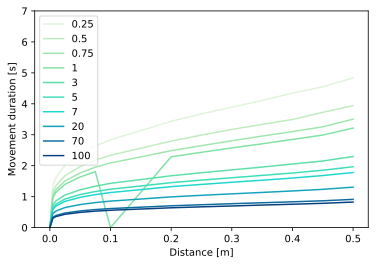

In [5]:
#%% Figure 1: distance / time 

f,ax = plt.subplots()
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = duration.copy()
  y = y[v,:]
  y = y.T
  ytemp = np.concatenate(([0],y))
  
  xtemp = np.concatenate(([0],xtemp))
  inds = ytemp !=0
  plt.plot(xtemp,ytemp,label=loopValuation[v],color = distcolors[v].get_hex())

plt.legend()
# %%
plt.xlabel("Distance [m]")
plt.ylabel("Movement duration [s]")
ax.set_ylim(0,7)


In [3]:
nDist

13

In [ ]:
saveDict = {
  "tSol":duration.T,
  "maxspeed":peakhandspeed.T,
  "dists":distances.T,
  "rewards":rewards.T}
import scipy
scipy.io.savemat('simulationResults/results'+'.mat', saveDict)


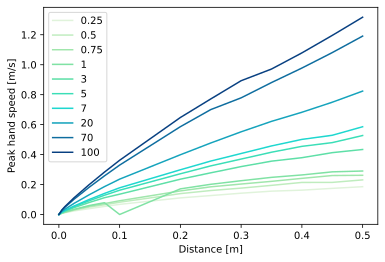

In [6]:
#%% Figure 2: distance peak speed / distance
f,ax = plt.subplots()
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = peakhandspeed.copy()
  y = y[v,:]
  ytemp = np.concatenate(([0],y))

  xtemp = np.concatenate(([0],xtemp))
  plt.plot(xtemp,ytemp, label=loopValuation[v],color = distcolors[v].get_hex())
  plt.xlabel("Distance [m]")
  plt.ylabel("Peak hand speed [m/s]")
  plt.legend()
# %%

In [ ]:
#%% Figure 3: 3 valuations, hand speed vs time
def plotBells(theList):
  for i in range(0,len(theList)):
    tempStruct = theList[i]  
    plt.plot(tempStruct.time,tempStruct.handspeed,distcolors[i].get_hex())

f,ax = plt.subplots()
plotBells(trajAll[1])
plotBells(trajAll[3])
plotBells(trajAll[-1])

plt.ylabel("Hand speed [m/s]")
plt.xlabel("Time [s]")


In [ ]:
# #%% Figure 4: COST plot. 
# f,ax = plt.subplots()
# v = np.where(loopValuation ==1)

# xtemp = loopdist.copy()
# xtemp = np.concatenate(([0],xtemp))

# y = workCost.copy()
# y = y[:,v]
# ytemp = np.concatenate(([0],y))
# y2 = frCost.copy()
# y2 = y2[:,v]
# y2temp = np.concatenate([0],y2)

# plt.plot(xtemp,ytemp, label=loopValuation[v],color = distcolors[v])
# plt.plot(xtemp,ytemp, label=loopValuation[v],color = distcolors[v])
# d
# plt.xlabel("Distance [m]")
# plt.ylabel("Peak hand speed [m/s]")
# plt.legend()
# # %%
